# Amazon Stock Forcasting with Pytorch and LSTM

In [43]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch

import torch.nn as nn
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"
data = pd.read_csv('AMZN.csv')

In [44]:
data = data[['Date','Close']]

In [45]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

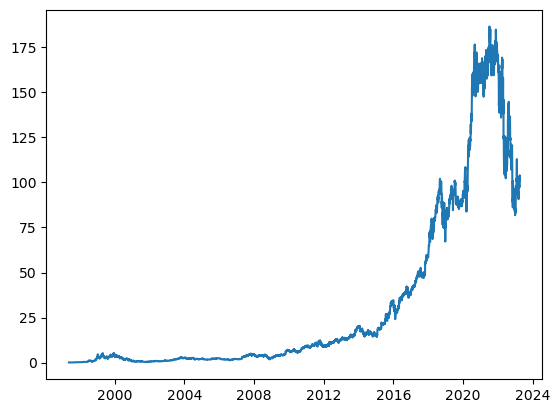

In [46]:
data['Date'] = pd.to_datetime(data['Date'])
plt.plot(data['Date'],data['Close'])

In [47]:
from copy import deepcopy as dc

def prepare_dataframe_for_lstm(df,n_steps):
    df = dc(df)

    df.set_index('Date',inplace=True)
    for i in range(1,n_steps+1):
        df[f'Close(t-{i})'] = df['Close'].shift(i)
    df.dropna(inplace=True)
    return df

lookback = 7
shift_df = prepare_dataframe_for_lstm(data,lookback)
shift_df


,Close,Close(t-1),Close(t-2),Close(t-3),Close(t-4),Close(t-5),Close(t-6),Close(t-7)
Date,,,,,,,,
1997-05-27,0.079167,0.075000,0.069792,0.071354,0.081771,0.085417,0.086458,0.097917
1997-05-28,0.076563,0.079167,0.075000,0.069792,0.071354,0.081771,0.085417,0.086458
1997-05-29,0.075260,0.076563,0.079167,0.075000,0.069792,0.071354,0.081771,0.085417
1997-05-30,0.075000,0.075260,0.076563,0.079167,0.075000,0.069792,0.071354,0.081771
1997-06-02,0.075521,0.075000,0.075260,0.076563,0.079167,0.075000,0.069792,0.071354
...,...,...,...,...,...,...,...,...
2023-03-30,102.000000,100.250000,97.239998,98.040001,98.129997,98.709999,98.699997,100.610001
2023-03-31,103.290001,102.000000,100.250000,97.239998,98.040001,98.129997,98.709999,98.699997
2023-04-03,102.410004,103.290001,102.000000,100.250000,97.239998,98.040001,98.129997,98.709999


In [48]:
shifted_df_as_np = shift_df.to_numpy()
shifted_df_as_np

array([[7.91670000e-02, 7.50000000e-02, 6.97920000e-02, ...,
        8.54170000e-02, 8.64580000e-02, 9.79170000e-02],
       [7.65630000e-02, 7.91670000e-02, 7.50000000e-02, ...,
        8.17710000e-02, 8.54170000e-02, 8.64580000e-02],
       [7.52600000e-02, 7.65630000e-02, 7.91670000e-02, ...,
        7.13540000e-02, 8.17710000e-02, 8.54170000e-02],
       ...,
       [1.02410004e+02, 1.03290001e+02, 1.02000000e+02, ...,
        9.80400010e+01, 9.81299970e+01, 9.87099990e+01],
       [1.03949997e+02, 1.02410004e+02, 1.03290001e+02, ...,
        9.72399980e+01, 9.80400010e+01, 9.81299970e+01],
       [1.01099998e+02, 1.03949997e+02, 1.02410004e+02, ...,
        1.00250000e+02, 9.72399980e+01, 9.80400010e+01]])

In [49]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(-1,1))
shifted_df_as_np = scaler.fit_transform(shifted_df_as_np)

shifted_df_as_np

array([[-0.99991063, -0.99995531, -1.        , ..., -0.99983244,
        -0.99982128, -0.99969839],
       [-0.99993855, -0.99991063, -0.99994415, ..., -0.99987154,
        -0.99983244, -0.99982128],
       [-0.99995253, -0.99993855, -0.99989946, ..., -0.99998325,
        -0.99987154, -0.99983244],
       ...,
       [ 0.09747299,  0.10690997,  0.09308121, ...,  0.0506149 ,
         0.05158   ,  0.05779984],
       [ 0.11398769,  0.09747299,  0.10691495, ...,  0.04203581,
         0.0506149 ,  0.05158   ],
       [ 0.08342464,  0.11398769,  0.09747802, ...,  0.07431453,
         0.04203581,  0.0506149 ]])

In [50]:
X = shifted_df_as_np[:,1:]
y = shifted_df_as_np[:,0]
X.shape,y.shape

((6509, 7), (6509,))

In [51]:
X = dc(np.flip(X,axis=1))
X

array([[-0.99969839, -0.99982128, -0.99983244, ..., -0.99998325,
        -1.        , -0.99995531],
       [-0.99982128, -0.99983244, -0.99987154, ..., -1.        ,
        -0.99994415, -0.99991063],
       [-0.99983244, -0.99987154, -0.99998325, ..., -0.99994415,
        -0.99989946, -0.99993855],
       ...,
       [ 0.05779984,  0.05158   ,  0.0506149 , ...,  0.07431453,
         0.09308121,  0.10690997],
       [ 0.05158   ,  0.0506149 ,  0.04203581, ...,  0.09308121,
         0.10691495,  0.09747299],
       [ 0.0506149 ,  0.04203581,  0.07431453, ...,  0.10691495,
         0.09747802,  0.11398769]])

In [52]:
split_index = int(len(X)*0.95)
split_index

6183

In [53]:
X_train = X[:split_index]
X_test = X[split_index:]
y_train = y[:split_index]
y_test = y[split_index:]

In [54]:
X_train = X_train.reshape((-1,lookback,1))
X_test = X_test.reshape((-1,lookback,1))

y_train = y_train.reshape((-1,1))
y_test = y_test.reshape((-1,1))

In [55]:
X_train = torch.tensor(X_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)


In [56]:
from torch.utils.data import Dataset
class TimeSeriesDataset(Dataset):
    def __init__(self,X,y):
        self.X = X
        self.y = y
    
    def __len__(self):
        return len(self.X)

    def __getitem__(self,i):
        return self.X[i],self.y[i]

train_dataset = TimeSeriesDataset(X_train,y_train)
test_dataset = TimeSeriesDataset(X_test,y_test)

In [57]:
from torch.utils.data import DataLoader

batch_size = 16
train_loader = DataLoader(train_dataset,batch_size=batch_size,shuffle=True)
test_loader = DataLoader(test_dataset,batch_size=batch_size,shuffle=False)

In [58]:
class LSTM(nn.Module):
    def __init__(self,input_size,hidden_size,num_stacked_layers):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_stzcked_layers = num_stacked_layers
        self.lstm = nn.LSTM(input_size,hidden_size,num_stacked_layers,batch_first=True)
        self.fc = nn.Linear(hidden_size,1)
    
    def forward(self,x):
        batch_size = x.size(0)
        h0 = torch.zeros(self.num_stzcked_layers,batch_size,self.hidden_size).to(device)
        c0 = torch.zeros(self.num_stzcked_layers,batch_size,self.hidden_size).to(device)
        out,_ = self.lstm(x,(h0,c0))
        out = self.fc(out[:,-1,:])
        return out
model = LSTM(1,4,1)
model.to(device)


LSTM(
  (lstm): LSTM(1, 4, batch_first=True)
  (fc): Linear(in_features=4, out_features=1, bias=True)
)

In [59]:
def train_one_epoch():
    model.train(True)
    print(f'Epoch:{epoch+1}')
    running_loss = 0.0

    for batch_index,batch in enumerate(train_loader):
        x_batch,y_batch = batch[0].to(device),batch[1].to(device)

        output = model(x_batch)
        loss = loss_function(output,y_batch)
        running_loss += loss.item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch_index % 100 == 99:
            avg_loss_across_batches = running_loss/100
            print('Batch {0}, Loss:{1:3f}'.format(batch_index,avg_loss_across_batches))
            running_loss = 0.0
    print()



In [60]:
def validate_one_epoch():
    model.train(False)
    running_loss = 0.0

    for batch_index,batch in enumerate(train_loader):
        x_batch,y_batch = batch[0].to(device),batch[1].to(device)

        with torch.no_grad():
            output = model(x_batch)
            loss = loss_function(output,y_batch)
            running_loss += loss.item()

        avg_loss_across_batches = running_loss/len(test_loader)
    print('Val Loss: {0:3f}'.format(avg_loss_across_batches))
    print('************************************************')
    print()

In [61]:
learning_rate = 0.001
num_epoch = 10
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(),lr=learning_rate)

for epoch in range(num_epoch):
    train_one_epoch()
    validate_one_epoch()

Epoch:1
Batch 99, Loss:1.775553
Batch 199, Loss:1.172935
Batch 299, Loss:0.693530

Val Loss: 3.983293
************************************************

Epoch:2
Batch 99, Loss:0.159004
Batch 199, Loss:0.078207
Batch 299, Loss:0.037205

Val Loss: 0.227544
************************************************

Epoch:3
Batch 99, Loss:0.009794
Batch 199, Loss:0.008163
Batch 299, Loss:0.005540

Val Loss: 0.079170
************************************************

Epoch:4
Batch 99, Loss:0.003742
Batch 199, Loss:0.002752
Batch 299, Loss:0.001878

Val Loss: 0.023659
************************************************

Epoch:5
Batch 99, Loss:0.001091
Batch 199, Loss:0.000988
Batch 299, Loss:0.000853

Val Loss: 0.011882
************************************************

Epoch:6
Batch 99, Loss:0.000650
Batch 199, Loss:0.000560
Batch 299, Loss:0.000463

Val Loss: 0.007461
************************************************

Epoch:7
Batch 99, Loss:0.000385
Batch 199, Loss:0.000346
Batch 299, Loss:0.000331

Val L

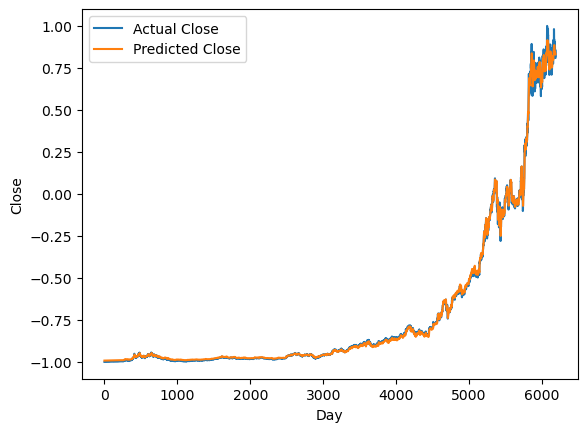

In [62]:
with torch.no_grad():
    predicted = model(X_train.to(device)).to('cpu').numpy()

plt.plot(y_train,label='Actual Close')
plt.plot(predicted,label='Predicted Close')
plt.xlabel('Day')
plt.ylabel('Close')
plt.legend()
plt.show()

In [63]:
train_predictions = predicted.flatten()

dummies = np.zeros((X_train.shape[0],lookback+1))
dummies[:,0] = train_predictions
dummies = scaler.inverse_transform(dummies)

train_predictions = dc(dummies[:,0])
train_predictions

array([  0.81061918,   0.81136397,   0.81144178, ..., 171.14594854,
       170.61448637, 170.76437784])

In [64]:
dummies = np.zeros((X_train.shape[0],lookback+1))
dummies[:,0] = y_train.flatten()
dummies = scaler.inverse_transform(dummies)

new_y_train = dc(dummies[:,0])
new_y_train

array([7.91646265e-02, 7.65634249e-02, 7.52572660e-02, ...,
       1.69091505e+02, 1.73315001e+02, 1.68871003e+02])

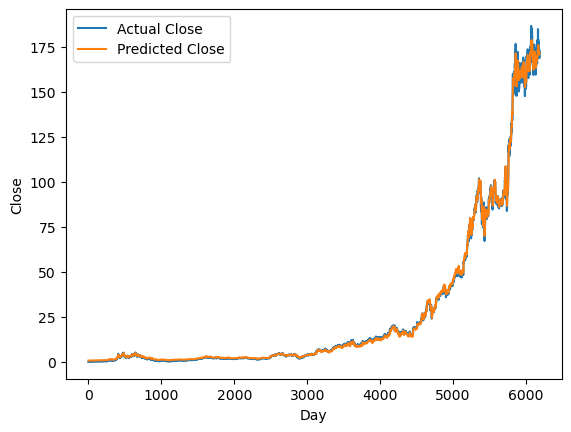

In [65]:
plt.plot(new_y_train,label='Actual Close')
plt.plot(train_predictions,label='Predicted Close')
plt.xlabel('Day')
plt.ylabel('Close')
plt.legend()
plt.show()

In [66]:
test_prediction = model(X_test.to(device)).detach().cpu().numpy().flatten()
dummies = np.zeros((X_test.shape[0],lookback+1))
dummies[:,0] = test_prediction
dummies = scaler.inverse_transform(dummies)

test_prediction = dc(dummies[:,0])
test_prediction

array([170.04066574, 169.62725811, 168.90242328, 168.93465483,
       169.17891211, 169.37192905, 169.21928632, 169.38485724,
       169.25713158, 169.08429618, 168.48748716, 168.61411232,
       168.25825904, 167.39446558, 166.43869629, 165.54511129,
       164.6046046 , 164.64257214, 164.63966524, 163.9950119 ,
       163.73969396, 162.89962812, 161.60641962, 159.43789567,
       155.22666143, 152.18843017, 148.58565479, 145.52724754,
       143.68333465, 143.91380778, 146.01854671, 148.29376996,
       149.98954219, 148.14896973, 151.37110261, 153.82657023,
       156.44065   , 158.39989951, 159.45218004, 158.96071968,
       158.85016306, 158.54896837, 158.647764  , 157.94102642,
       156.96373052, 155.67021077, 153.27619377, 152.91850075,
       153.31337205, 153.731304  , 153.66915307, 153.9154335 ,
       153.08151495, 151.72444362, 148.121168  , 144.6396264 ,
       142.93027011, 144.08732127, 144.97639864, 144.95018097,
       146.5457736 , 149.26356239, 152.2992647 , 155.47

In [67]:
dummies = np.zeros((X_test.shape[0],lookback+1))
dummies[:,0] = y_test.flatten()
dummies = scaler.inverse_transform(dummies)

new_y_test = dc(dummies[:,0])
new_y_test

array([170.01749949, 167.07899763, 170.41700626, 171.03700377,
       171.0684961 , 169.66949429, 170.66099675, 169.20100565,
       168.64449858, 166.71699707, 170.40449492, 167.52200227,
       164.35699578, 163.25399737, 162.55400179, 161.48599177,
       165.36199892, 165.20699954, 161.21400501, 162.13799851,
       158.91749416, 156.29899568, 151.66749509, 142.64300408,
       144.54400445, 139.98599336, 138.87249844, 139.63749627,
       143.97799855, 149.57350001, 151.19349835, 150.61250219,
       138.84550541, 157.63949825, 157.93550165, 161.41349717,
       161.18949925, 159.003495  , 153.29350176, 155.1670061 ,
       156.51049894, 158.10049453, 154.6524962 , 152.60149876,
       150.19749381, 144.82699629, 151.35800212, 153.78849709,
       153.56300403, 151.14199678, 152.05250627, 147.89849848,
       145.64100565, 137.45300383, 136.01449488, 139.27900567,
       146.81750468, 145.52450739, 141.8529947 , 147.36650272,
       153.10400311, 157.23899657, 161.25050521, 161.49

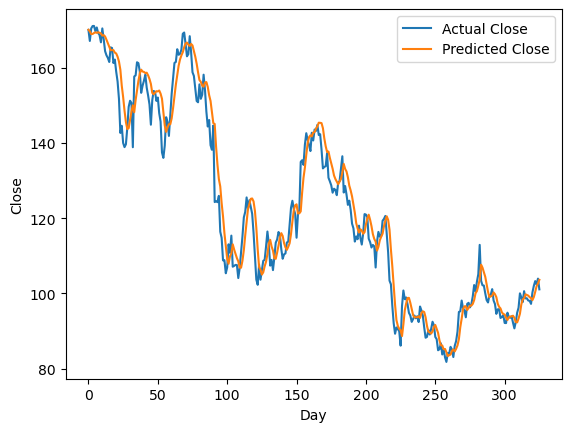

In [68]:
plt.plot(new_y_test,label='Actual Close')
plt.plot(test_prediction,label='Predicted Close')
plt.xlabel('Day')
plt.ylabel('Close')
plt.legend()
plt.show()